## **Age Detection**  

Fangqing Wu 001305642  

---
**Partial Abstract**  
This is the sub-part of project.   
These parts are included:   
1. Basic view, to see the dataset distribution, especially the related feature 'Young'. 
2. Split the dataset based on the given partition.  
3. Process the image. 
4. Use CNN model and tuning the model for a better result.  
5. Interprete the process of training. 

### **0. Import part**  
For this implementation, tensorflow and keras would be used to build CNN model. 

In [ ]:
import pandas as pd
import numpy as np   
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import json
from os import path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from random import randint

In [ ]:
# !pip install keras
# !pip install tensorflow-gpu

In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model, load_model 
from keras.layers import Conv2D,Dense,Flatten,BatchNormalization,Add,Activation,Dropout,\
            GlobalAveragePooling2D,MaxPooling2D,AveragePooling2D, Input
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils, to_categorical
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [ ]:
# !pip install opencv-python
# !pip install pickle-mixin
# !pip install torch

In [ ]:
import cv2 as cv
# import pickle
import torch

Find gpu

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device=torch.device("cuda")

In [ ]:
# GPU number
torch.cuda.device_count()

1

### **1. Basic view**  
According to the files, three main parts are included in this dataset: Attributes, Landmarks Align, Partition, Bounding Box. Among all these, Attributes is what majorly used here. 

#### Attributes

* Get the attributes of the dataset from 'list_attr_celeba.csv' 

In [ ]:
dattr = pd.read_csv('list_attr_celeba.csv')
dattr.set_index('image_id', inplace=True)

# As the values in dataset is 1 & -1, replace -1 by 0
dattr.replace(to_replace=-1, value=0, inplace=True) 

dattr.head()

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
# Print shape
dattr.shape

(202599, 40)

In [ ]:
# Print features 
dattr.columns

Index(['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes',
       'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
       'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
       'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
       'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
       'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
       'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
       'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
       'Wearing_Necklace', 'Wearing_Necktie', 'Young'],
      dtype='object')

    The feature 'Young' would be used to detect the figure is young or not. 

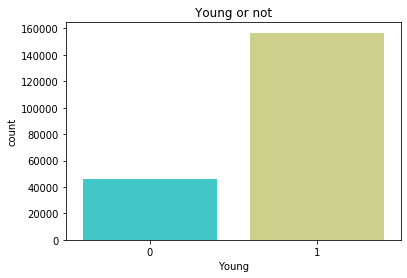

In [ ]:
# Plot the counting result
plt.title('Young or not')
sns.countplot(x='Young', data=dattr, palette='rainbow')
plt.show()

* Get a random image example

In [ ]:
# Image directory
IMG_URL ='img/img_align_celeba/'

# Random choose a picture
img_index = '007968.jpg'
IMG_EXP = IMG_URL + img_index

    Plot picture with attributes

Image size:  (178, 218)
Features: 


Smiling       1
Male          0
Young         1
Eyeglasses    0
Black_Hair    1
Name: 007968.jpg, dtype: int64

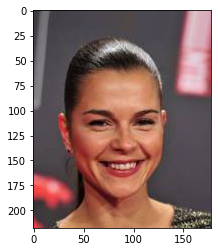

In [ ]:
# Load the random image and some attributes
img = load_img(IMG_EXP)
print('Image size: ', img.size)
plt.imshow(img)
print('Features: ')
dattr.loc[img_index][['Smiling','Male','Young', 'Eyeglasses', 'Black_Hair']] 

#### Landmarks Align

In [ ]:
dalign = pd.read_csv('list_landmarks_align_celeba.csv')
dalign.set_index('image_id', inplace=True)

# As the values in dataset is 1 & -1, replace -1 by 0
dalign.replace(to_replace=-1, value=0, inplace=True) 

dalign.head()

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000001.jpg,69,109,106,113,77,142,73,152,108,154
000002.jpg,69,110,107,112,81,135,70,151,108,153
000003.jpg,76,112,104,106,108,128,74,156,98,158
000004.jpg,72,113,108,108,101,138,71,155,101,151
000005.jpg,66,114,112,112,86,119,71,147,104,150


    Combine with image, plot the example

In [ ]:
# Create coordinates matrix
points = list(dalign.loc[img_index])
print(points)

[67, 113, 110, 112, 94, 137, 66, 151, 110, 149]


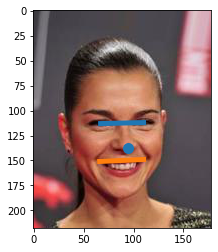

In [ ]:
# Plot
fig, ax = plt.subplots()

img = plt.imread(IMG_EXP)
ax.imshow(img)

ax.plot([points[0], points[2]], [points[1], points[3]], linewidth=5)
ax.plot([points[6], points[8]], [points[7], points[9]], linewidth=5)
ax.scatter(points[4], points[5], linewidth=5)

#### Partition

* Get the attributes of the dataset from 'list_eval_partition.csv' 

In [ ]:
dpart = pd.read_csv('list_eval_partition.csv')
dpart.set_index('image_id', inplace=True)

dpart.head()

,partition
image_id,
000001.jpg,0
000002.jpg,0
000003.jpg,0
000004.jpg,0
000005.jpg,0


In [ ]:
dpart['partition'].unique()

array([0, 1, 2])

    Three partitions are divided, which could be used as training set, validation set and test set. 

In [ ]:
dpart['partition'].value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

    0: train, 1:validation, 2: test 
    The validation set and test set should not have much difference, on account of a good training result. 

### 2. Split csv data, get indexes

    Define a function to select different csv sets

In [ ]:
# Select partition and combine 'attribution' & 'landmarks'
def apart(partition): 
    condition = dpart['partition'] == partition
    return pd.concat([dattr[condition], dalign[condition]], axis=1)

     On account of running efficiency, sample it. 
     ! Also the memory would break down and Gpu is not quite used in discovery... 

In [ ]:
# Sample fraction ratio
SAMPLE = 0.35

    The sample ratio could be more to get a more accurate result. But due to the limitation of computating, only 35% applied.   

**Train** 

In [ ]:
# Get the data  - array
df_train = apart(0).sample(frac=SAMPLE, random_state=42)
# Get the train set indexes
train_index = df_train.index.values
len(train_index)

56970

**Validation**

In [ ]:
# Get the data  - array
df_validation = apart(1).sample(frac=SAMPLE, random_state=42)
# Get the validation set indexes
validation_index = df_validation.index.values
len(validation_index)

6953

**Test**

In [ ]:
# Get the data  - array
df_test = apart(2).sample(frac=SAMPLE, random_state=42)
# Get the test set indexes
test_index = df_test.index.values
len(test_index)

6987

The results here are all array structure.   
**?Why array**  
For image extract, the array was used instead all other data structures.   
Though the final input to the training model should be the numpy arrays, here while extracting the images, array still the best structure for efficiencyand running time.

### 3. Preprocess and split image dataset. 

    Check the effect after normalization, show the first 6 images from dataset

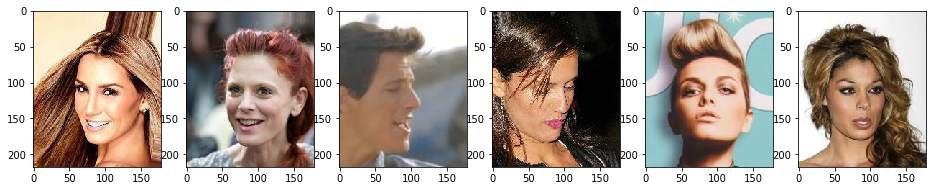

In [ ]:
# Original images in dataset
img_indexes = list(range(6))
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in img_indexes:
    img = load_img(IMG_URL+'00000'+str(i+1)+'.jpg')
    ax[i].imshow(img)

(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)
(218, 178, 3)


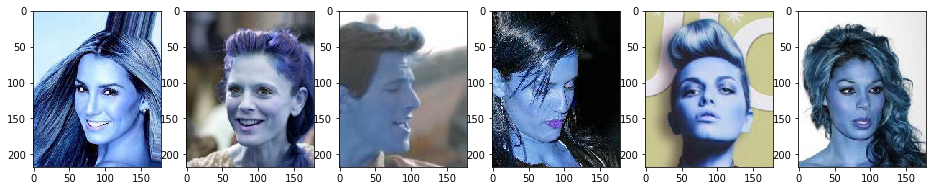

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i in img_indexes:
    img = load_img(IMG_URL+'00000'+str(i+1)+'.jpg')
    rgb = cv.cvtColor(np.float32(img), cv.COLOR_BGR2RGB)
    img = rgb / 255.0
    print(img.shape)
    ax[i].imshow(img)

After normalization, the result have already shrinked to \[-1, 1\]. 
And the images are distorted in color. 

    Extract the data, from local dir into array

In [ ]:
# Define functions to load image files as dataset

# For train & validation
def readimgs(indexes):
    res = []
    for index in indexes:
        # Read image
        img = cv.imread(IMG_URL + index)
        # Change default BGR to RGB
        rgb = cv.cvtColor(np.float32(img), cv.COLOR_BGR2RGB)
        # Normalization
        img = rgb / 255.0
        res.append(img)
    return res

# For test
def readtest(indexes):
    res = []
    for index in indexes:
        # Read image
        res.append(cv.imread(IMG_URL + index))
    return res
    

**Train**

In [ ]:
img_train = readimgs(train_index)

In [ ]:
# X to numpy array
X_train = np.array(img_train)
X_train.shape

(56970, 218, 178, 3)

In [ ]:
# Y label
Y_train = df_train[['Young']]
Y_train = to_categorical(Y_train)
Y_train.shape

(56970, 2)

**Validation**

In [ ]:
img_validation = readimgs(validation_index)

In [ ]:
# X to numpy array
X_validation = np.array(img_validation)
X_validation.shape

(6953, 218, 178, 3)

In [ ]:
# Y label
Y_validation = df_validation[['Young']]
Y_validation = to_categorical(Y_validation)
Y_validation.shape

(6953, 2)

**Test**

In [ ]:
img_test = readtest(test_index)

In [ ]:
# X to numpy array
X_test = np.array(img_test)
X_test.shape

(6987, 218, 178, 3)

In [ ]:
# Y label
Y_test = df_test[['Young']]
Y_test = to_categorical(Y_test)
Y_test.shape

(6987, 2)

### 4. Train the model and predict

In [ ]:
# Set variable

# Parameters
# Batch size used in training 
BATCH_SIZE = 96
# Learning rate for training (default 0.0002)
LR = 0.0002
# Number of training epochs
EPOCHS = 8
# Input size for network
INPUT_SIZE = (218, 178, 3)

**CNN Model**   

In [ ]:
# Create the convolutional base

# Hyperparameters
# Padding = 'same' # case-insensitive
# Activation function = 'relu' & 'softmax'

inputs = Input(shape=INPUT_SIZE)
x = inputs
x = Conv2D(32,(3,3),padding='SAME',kernel_initializer='random_uniform',input_shape=INPUT_SIZE,activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))
x = MaxPooling2D((2,2))(x)
x = Conv2D(32,(3,3),padding='SAME',kernel_initializer='random_uniform',activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))

x = Conv2D(64,(3,3),padding='SAME',kernel_initializer='random_uniform',activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))
x = MaxPooling2D((2,2))(x)
x = Conv2D(64,(3,3),padding='SAME',kernel_initializer='random_uniform',activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))

x = Conv2D(128,(3,3),padding='SAME',kernel_initializer='random_uniform',activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))
x = MaxPooling2D((2,2))(x)
x = Conv2D(128,(3,3),padding='SAME',kernel_initializer='random_uniform',activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))

x = Conv2D(256,(3,3),padding='SAME',kernel_initializer='random_uniform',activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))
x = MaxPooling2D((3,3))(x)
x = Conv2D(256,(3,3),padding='SAME',kernel_initializer='random_uniform',activation='relu')(x)
x = BatchNormalization(axis=-1)(x)
# model.add(Activation('relu'))

out = Flatten()(x)
out = Dense(512)(out)
out = BatchNormalization()(out)
out = Activation('relu')(out)
out = Dropout(0.3)(out)
out = Dense(2)(out)
out = Activation('softmax')(out)

model = Model(inputs, out)

Set the loss function(categorical_crossentropy),  optimizer(adam) and metrics(accuracy).   
categorical_crossentropy: Computes the crossentropy loss between the labels and predictions, expecting labels to be provided in a one_hot representation  
adam: implements the Adam algorithm, a stochastic gradient descent method   


In [ ]:
adam = Adam(lr=LR)
model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])
# Get a summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 218, 178, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 178, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 218, 178, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 89, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 89, 32)       9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 89, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 89, 64)       18496 

In [ ]:
# Set callbacks
best_model = ModelCheckpoint('cnn_weights.h5', monitor='val_acc', 
                             verbose=1, save_best_only=True, mode='max')
# Fit the model with data
hist = model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, 
        validation_data=(X_validation, Y_validation), callbacks=[best_model])

Epoch 1/8
594/594 [==============================] - 2005s 3s/step - loss: 0.5409 - accuracy: 0.7964 - val_loss: 0.4643 - val_accuracy: 0.7802
Epoch 2/8
594/594 [==============================] - 2000s 3s/step - loss: 0.3544 - accuracy: 0.8545 - val_loss: 0.3507 - val_accuracy: 0.8552
Epoch 3/8
594/594 [==============================] - 1998s 3s/step - loss: 0.3058 - accuracy: 0.8730 - val_loss: 0.5696 - val_accuracy: 0.8057
Epoch 4/8
594/594 [==============================] - 1997s 3s/step - loss: 0.2811 - accuracy: 0.8845 - val_loss: 0.6715 - val_accuracy: 0.6505
Epoch 5/8
594/594 [==============================] - 1996s 3s/step - loss: 0.2615 - accuracy: 0.8917 - val_loss: 0.3485 - val_accuracy: 0.8555
Epoch 6/8
594/594 [==============================] - 1999s 3s/step - loss: 0.2391 - accuracy: 0.9016 - val_loss: 0.3315 - val_accuracy: 0.8580
Epoch 7/8
594/594 [==============================] - 1988s 3s/step - loss: 0.2231 - accuracy: 0.9083 - val_loss: 0.3596 - val_accuracy: 0.8621

In [ ]:
# Sava model
model.save('cnn.h5', save_format='h5')

**Prediction**

Create sample images to predict

In [ ]:
# Generate random image index
randimg = [] # random image
for _ in range(6):
    randimg.append(str(randint(100000, 200000)) + 
                   '.jpg')
print(randimg)

['147568.jpg', '160507.jpg', '171678.jpg', '148173.jpg', '154689.jpg', '131661.jpg']


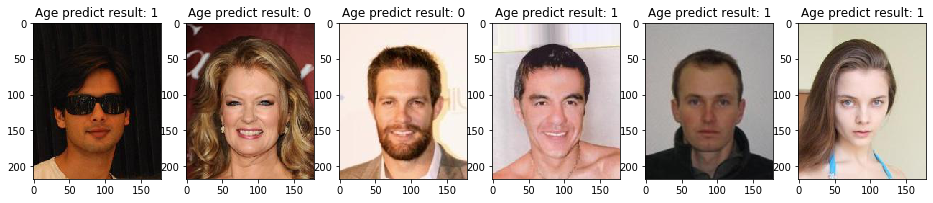

In [ ]:
# Plot for prediction 
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=[16, 9])
for i, im in zip(range(6), randimg):
    img = load_img(IMG_URL + im)
    ax[i].imshow(img)
    # to array
    rgb = cv.cvtColor(np.float32(img), cv.COLOR_BGR2RGB)
    img = rgb / 255.0
    img = img[np.newaxis, ...] 
#     print(img.shape)
    # Predict
    result = model.predict(img)
    prediction = np.argmax(result)
    # Output
    ax[i].set_title('Age predict result: ' + str(prediction)) 

    As we can tell, 1 -- Young & 0 -- Not Young

Predict X_test

**Evaluations**

Loss and Accuracy on validation

In [ ]:
# Plot loss function 
def plotloss(model):
    plt.figure(figsize=(15, 3))
    plt.plot(model.history['loss'], label = 'train')
    plt.plot(model.history['val_loss'], label = 'valid')
    plt.legend()
    plt.title('Loss Function')
    plt.show()
    
# Plot accuracy 
def plotaccu(model):
    plt.figure(figsize=(15, 3))
    plt.plot(model.history['accuracy'], label = 'train')
    plt.plot(model.history['val_accuracy'], label = 'valid')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

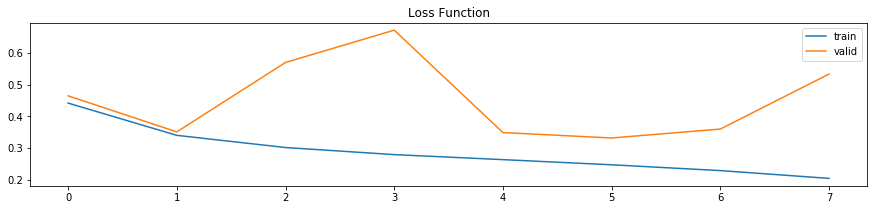

In [ ]:
# Plot loss function 
plotloss(hist)

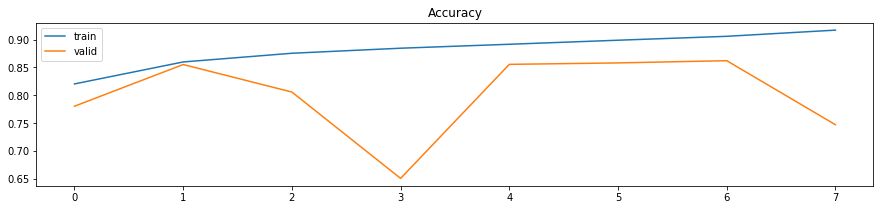

In [ ]:
# Plot accuracy
plotaccu(hist)

---
**Conclusion**  
The epochs are not set with too many, as the running limitation on memory and other hardwares. A better result would be achieve if more epochs could be run.   


---
**Reference**  
https://docs.opencv.org/master/d2/d96/tutorial_py_table_of_contents_imgproc.html   
https://keras.io/api/preprocessing/image/   
https://keras.io/api/losses/   
https://keras.io/api/optimizers/   
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html  